### Импорт библиотек

In [1]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils      # NumPy related tools
from PIL import Image
import seaborn as sns                 
from matplotlib import patches as mpatches
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [2]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
print(np.__version__)

import keras
print(keras.__version__)

import matplotlib
from matplotlib import pyplot as plt
print(matplotlib.__version__)

2.10.0-dev20220515
1.22.3
2.10.0
3.5.2


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Создание датасета

In [4]:
TARGET_SHAPE = (256, 256)  # Размер выходной картинки должен совпадать с размером фона
TARGET_TRAIN_SIZE = 1000 # Размер сгенерированного датасета для обучения
TARGET_TEST_SIZE = 100 # Размер сгенерированного датасета для обучения
MIN_SCALE_FACTOR = 2 # Минимальный коэффицент растяжения
MAX_SCALE_FACTOR = 4 # Максимальный коэффицент растяжения
MIN_LIGHT_FACTOR = 0.9 # Минимальный коэффицент яркости
MAX_LIGHT_FACTOR = 1 # Максимальный коэффицент яркости
MIN_ROTATE_ARG = -25 # Минимальный градус поворота
MAX_ROTATE_ARG = 25 # Максимальный градус поврота
MIN_NUM_DIGITS_PER_IMAGE = 0 # Минимальное кол-во чисел в выходной картинки
MAX_NUM_DIGITS_PER_IMAGE = 10 # Максимальное кол-во чисел в выходной картинки 
MAX_IOU = 0.1 # Максимальный коэфицент покрытия

In [5]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
def normal_mnist(tmp):
    tmp[tmp > 0.1] = 1 
    return tmp
X_test =  normal_mnist(X_test)
X_train =  normal_mnist(X_train)

##### Визуализация исходного датасета

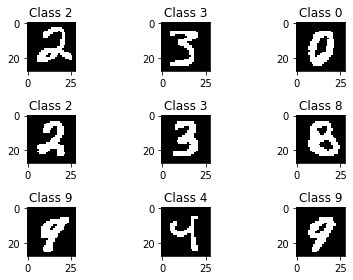

In [7]:
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
plt.tight_layout()

In [8]:
X_test.shape

(10000, 28, 28)

##### Пример фона

(256, 256)


<AxesSubplot:>

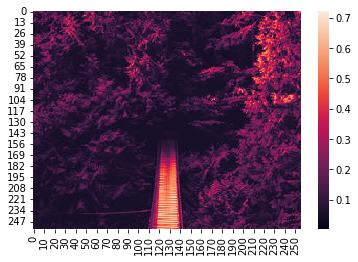

In [9]:
img = Image.open('./backgrounds/1.jpg').convert('L')
array = np.array(img) / 255
print(array.shape)
sns.heatmap(array)

##### Описание функций для генерации

In [10]:
from segmentation_dataset_generator import create_semantic_segmentation_data_from_digits

LIGHT_COEF = 10
BG_START_INDEX = 0
BG_END_INDEX = 50

def add_noise_to_dataset(input_data):
    new_dataset = []
    for index, i in enumerate(input_data):
        if index % 100 == 0:
            print(index)
        new_dataset.append(add_noise_background(i))
    return np.array(new_dataset)

def add_noise_background(input_data):
    # array = np.random.uniform(low=0.3, high=1, size=input_data.shape)
    index = np.random.randint(BG_START_INDEX, BG_END_INDEX)
    img = Image.open(f'./backgrounds/{index}.jpg').convert('L')
    array = np.array(img) / 255
    if index == 9 or index == 55:
        array = np.zeros((256,256,1))+1
        
    array =  np.reshape(array, input_data.shape)
    tmp = input_data
    tmp[tmp == 0] = array[tmp == 0]
    
    img = Image.fromarray(tmp.reshape((256,256))*255).convert('RGB').convert('L')
    img.save('tmp.jpg')
    img = np.array(Image.open('tmp.jpg').convert('L')).reshape((256,256,1)) / 255
    return img

def transformation(input_element):
    min_scale_factor = MIN_SCALE_FACTOR
    max_scale_factor = MAX_SCALE_FACTOR
    min_rotate_arg = MIN_ROTATE_ARG
    max_rotate_arg = MAX_ROTATE_ARG
    x = input_element.reshape((input_element.shape[0], input_element.shape[1]))
    new_size = (np.random.uniform(low=min_scale_factor, high=max_scale_factor) * np.array(x.shape)).astype(int)
    new_array = np.array(Image.fromarray(x).resize(size=new_size).rotate(np.random.uniform(low=min_rotate_arg, high=max_rotate_arg)))
    new_array = new_array / new_array.max()
    tmp = new_array
    tmp[tmp > 0] = np.random.uniform(low=MIN_LIGHT_FACTOR, high=MAX_LIGHT_FACTOR)
    new_array = tmp
    return new_array.reshape((new_array.shape[0], new_array.shape[1], 1))

def generate_dataset(X_test, y_test, num):
    X_test_reshaped = X_test.reshape((len(X_test), 28, 28, 1))
    input_data, target_data, overlaids, labels = create_semantic_segmentation_data_from_digits(
        digits=X_test_reshaped, 
        digit_labels=y_test,
        num_samples=num, 
        image_shape=TARGET_SHAPE,
        min_num_digits_per_image=MIN_NUM_DIGITS_PER_IMAGE,
        max_num_digits_per_image=MAX_NUM_DIGITS_PER_IMAGE,
        num_classes=10, 
        max_iou=MAX_IOU,
        labels_are_exclusive=False,
        target_is_whole_bounding_box=False,
        transformation=transformation,
    )
    input_data = add_noise_to_dataset(input_data)
    return input_data, target_data

In [11]:
X_seg_train, y_seg_train = generate_dataset(X_train, y_train, TARGET_TRAIN_SIZE)
BG_START_INDEX = 51
BG_END_INDEX = 100 
X_seg_test, y_seg_test = generate_dataset(X_test, y_test, TARGET_TEST_SIZE)

0


C:\Users\user\Projects\semantic-segmentation\segmentation_dataset_generator\array_overlay.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return output_array, np.array(arrays_overlaid), labels_overlaid, bounding_boxes_overlaid


100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
0


##### Визуализация сгенерированного датасета

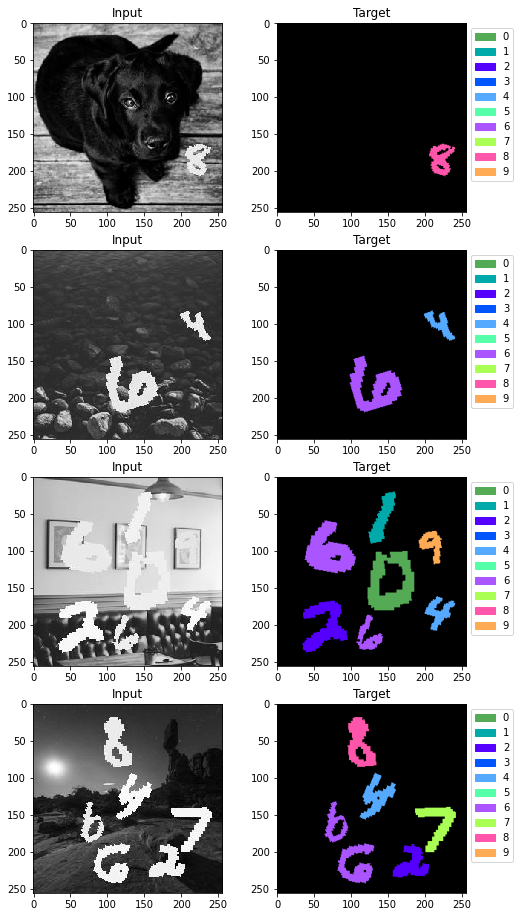

In [12]:
def show_X_y(X_seg_test, y_seg_test, threshold = 0):
    colors = np.array([
        [1, 2, 1],
        [0, 2, 2],
        [1, 0, 3],
        [0, 1, 3],
        [1, 2, 3],
        [1, 3, 2],
        [2, 1, 3],
        [2, 3, 1],
        [3, 1, 2],
        [3, 2, 1],
    ]) / 3

    def colorize_target(target):
        output_array = np.zeros((target.shape[0], target.shape[1], 3))
        for index in range(0,10):
            output_array[target[:,:,index] > threshold] = colors[index]
        return output_array

    legend_handles = []
    for i in range(0,10):
        legend_handles.append(mpatches.Patch(color=colors[i], label=str(i)))

    plt.rcParams['figure.figsize'] = (8,16) # Make the figures a bit bigger
    for i in range(0, 8, 2):
        plt.subplot(4,2,i+1)
        num = random.randint(0, len(X_seg_test) - 1)
        plt.imshow(X_seg_test[num], cmap='gray', interpolation='none')
        plt.title("Input")
        plt.subplot(4,2,i+2)
        plt.imshow(colorize_target(y_seg_test[num]))
        plt.title("Target")
        plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper left')

def show_X_pred_y(X_seg_test, y_seg_test):
    show_X_y(X_seg_test, y_seg_test, 0.5)
show_X_y(X_seg_test, y_seg_test)

##### Heatmap одного из input'ов

<AxesSubplot:>

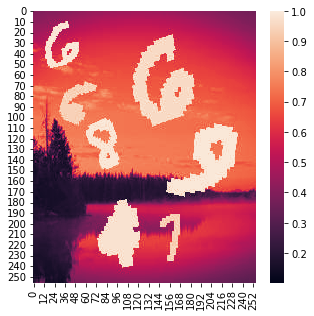

In [13]:
plt.rcParams['figure.figsize'] = (5,5) # Make the figures a bit bigger
num = random.randint(0, len(X_seg_test) - 1)
sns.heatmap(X_seg_test[num,:,:,0])
# X_seg_test

#### Простая модель

In [19]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=X_seg_train.shape[1:], padding="same")) # 3
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')) # 5
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')) # 7
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')) # 9

model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')) # 13
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')) # 17
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')) # 21
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')) # 25

model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 33
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 41
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 49
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 57

model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 65
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 73
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 81
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 89

model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 97
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 105
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 113
model.add(layers.Conv2D(filters=y_seg_train.shape[-1], kernel_size=(9, 9), activation='sigmoid', padding='same')) # 121
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      2

In [20]:
history = model.fit(X_seg_train, y_seg_train, epochs=50,
                    validation_data=(X_seg_test, y_seg_test))

Epoch 1/50
32/32 [==============================] - 34s 698ms/step - loss: 0.2420 - binary_accuracy: 0.9672 - recall: 0.0268 - precision: 0.0101 - val_loss: 0.0646 - val_binary_accuracy: 0.9901 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 21s 643ms/step - loss: 0.0620 - binary_accuracy: 0.9910 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0576 - val_binary_accuracy: 0.9901 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 21s 641ms/step - loss: 0.0513 - binary_accuracy: 0.9910 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0540 - val_binary_accuracy: 0.9901 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/50
32/32 [==============================] - 21s 652ms/step - loss: 0.0493 - binary_accuracy: 0.9910 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0533 - val_binary_accuracy: 0.9901 - val_recall: 0.0000e+00 - val_precision:

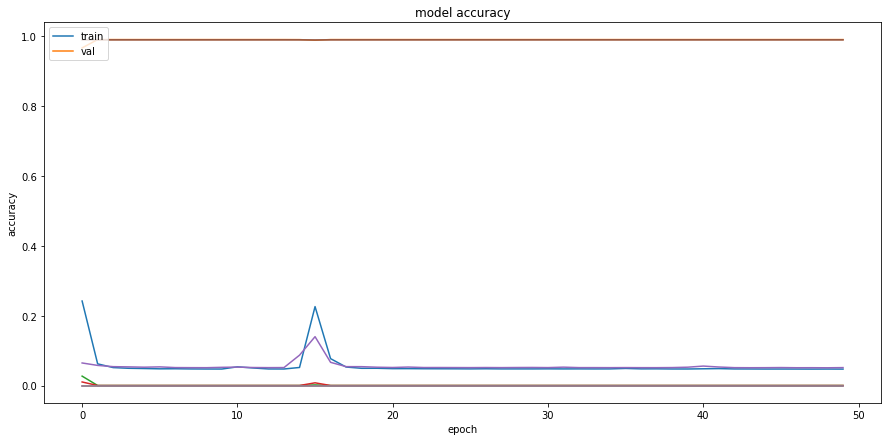

In [21]:
plt.rcParams['figure.figsize'] = (15,7) # Make the figures a bit bigger
plt.plot(history.history['loss'])
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['recall'])
plt.plot(history.history['precision'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_binary_accuracy'])
plt.plot(history.history['val_recall'])
plt.plot(history.history['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
test_y_predicted = model.predict(X_seg_test)

4/4 [==============================] - 0s 71ms/step


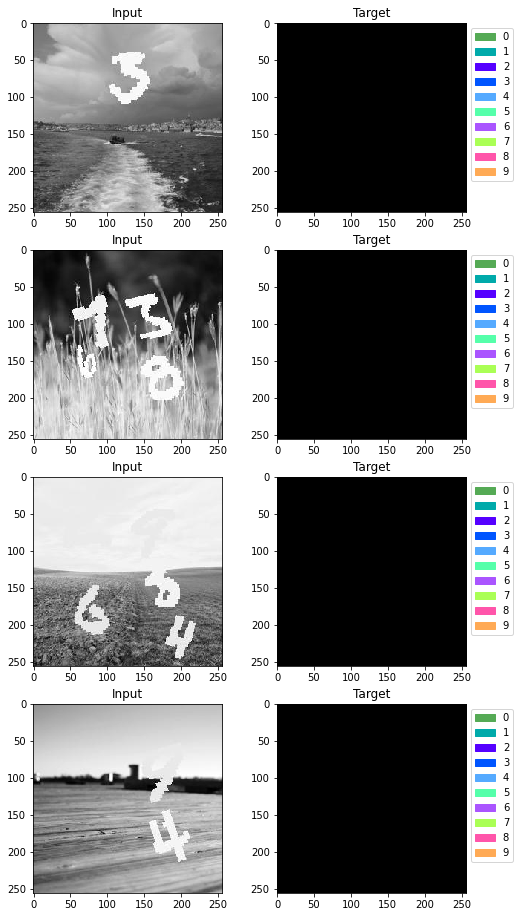

In [23]:
show_X_pred_y(X_seg_test, test_y_predicted)

Example 46


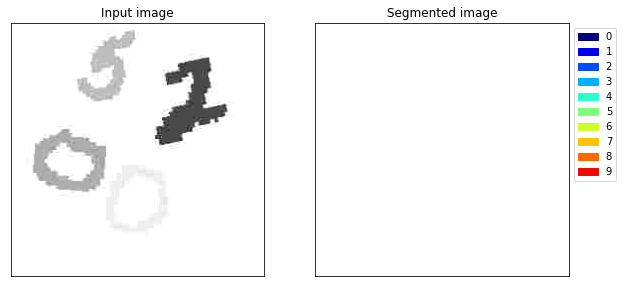

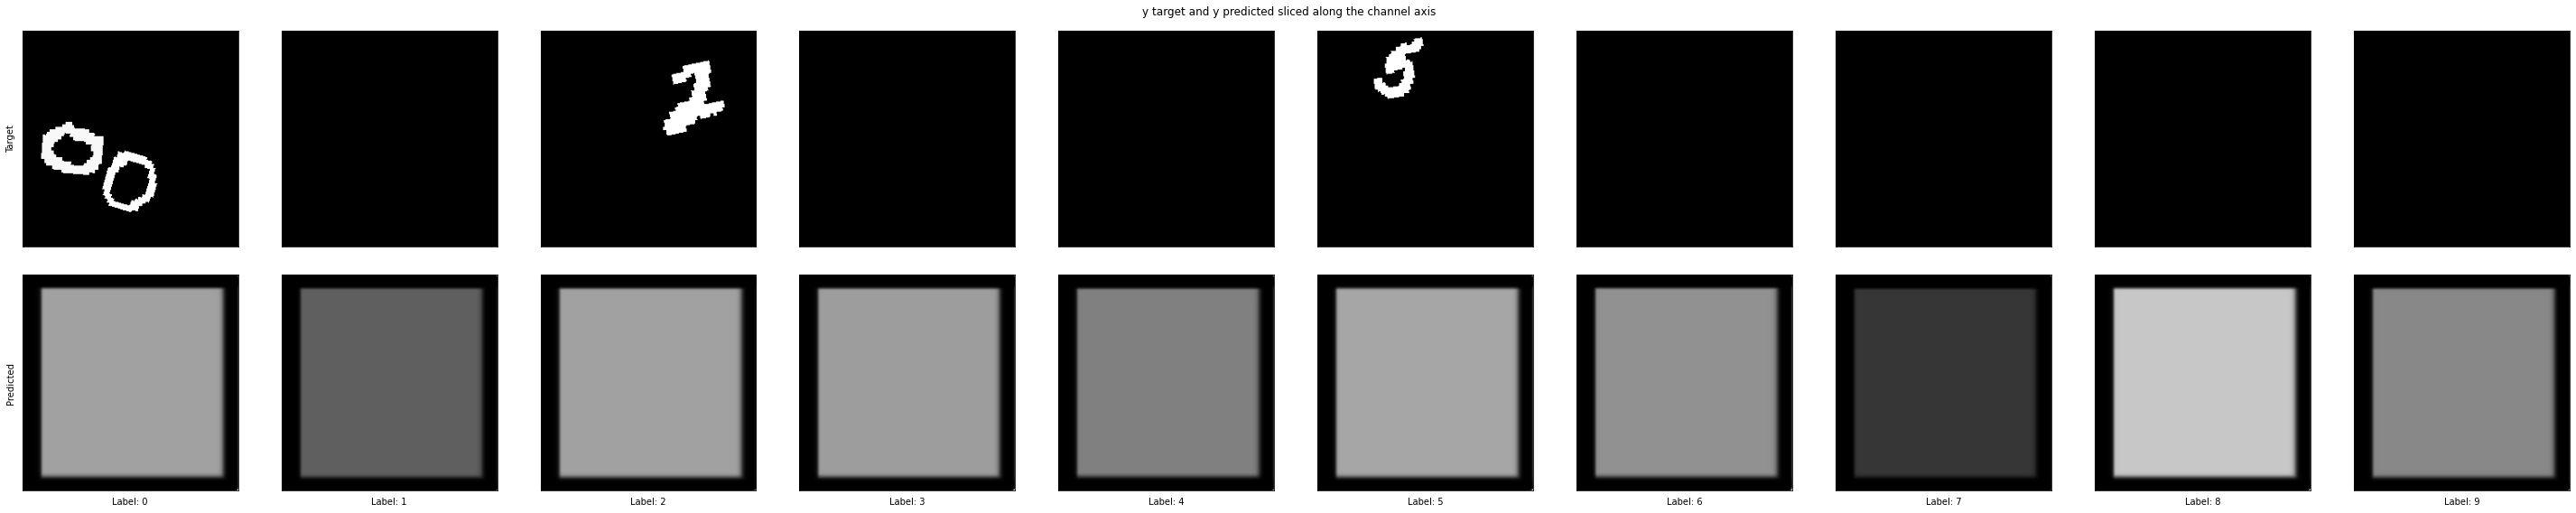

Example 29


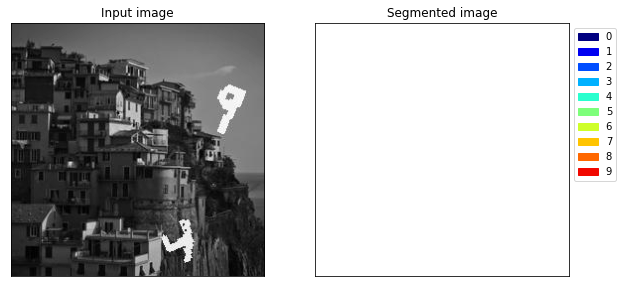

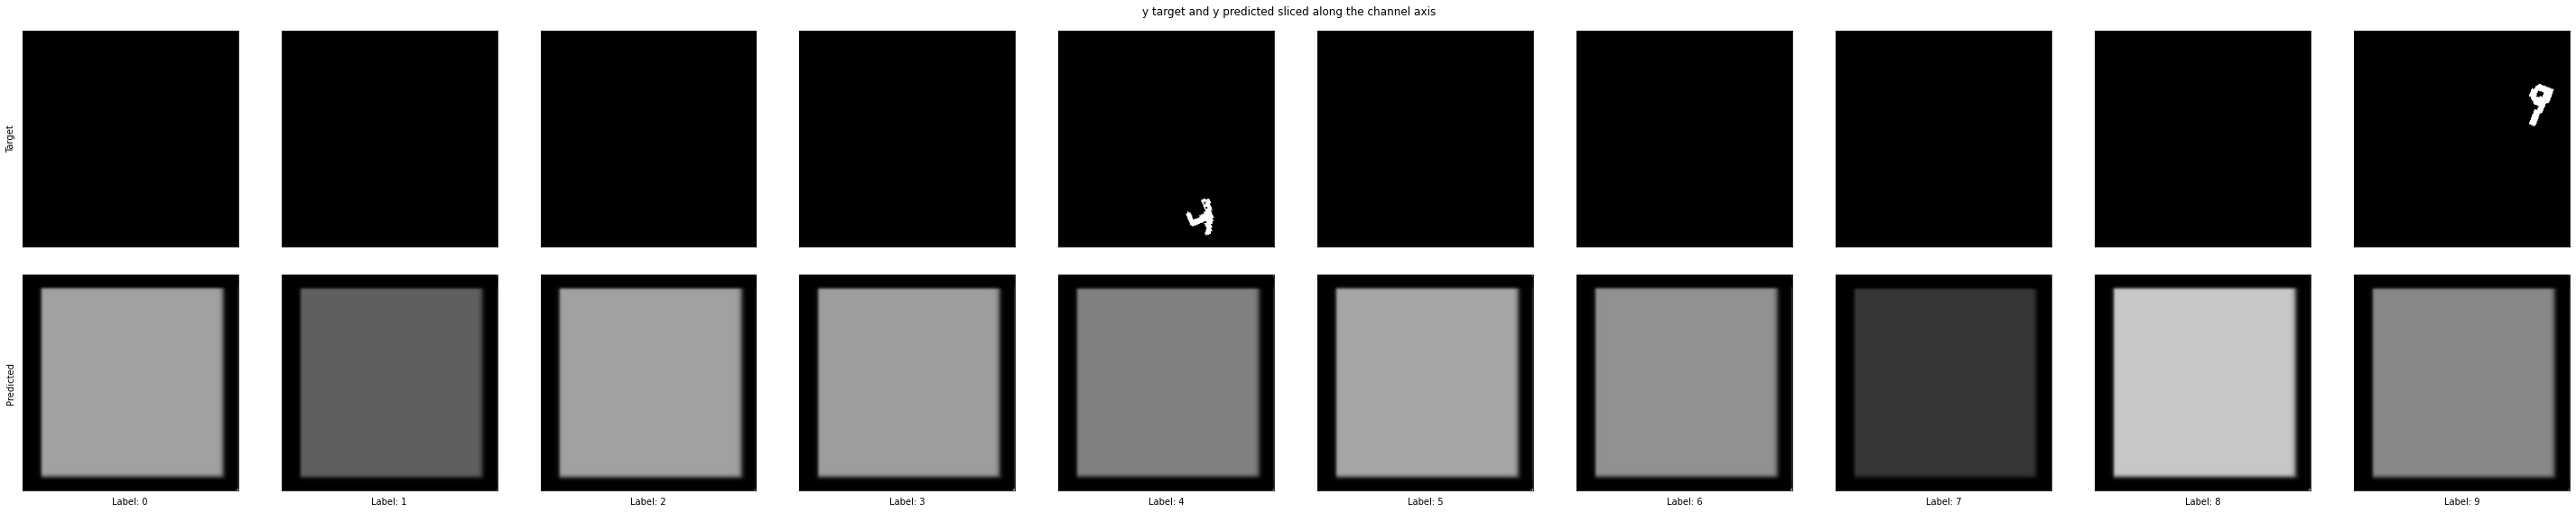

Example 12


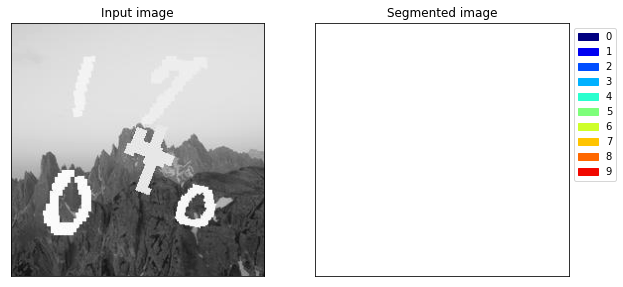

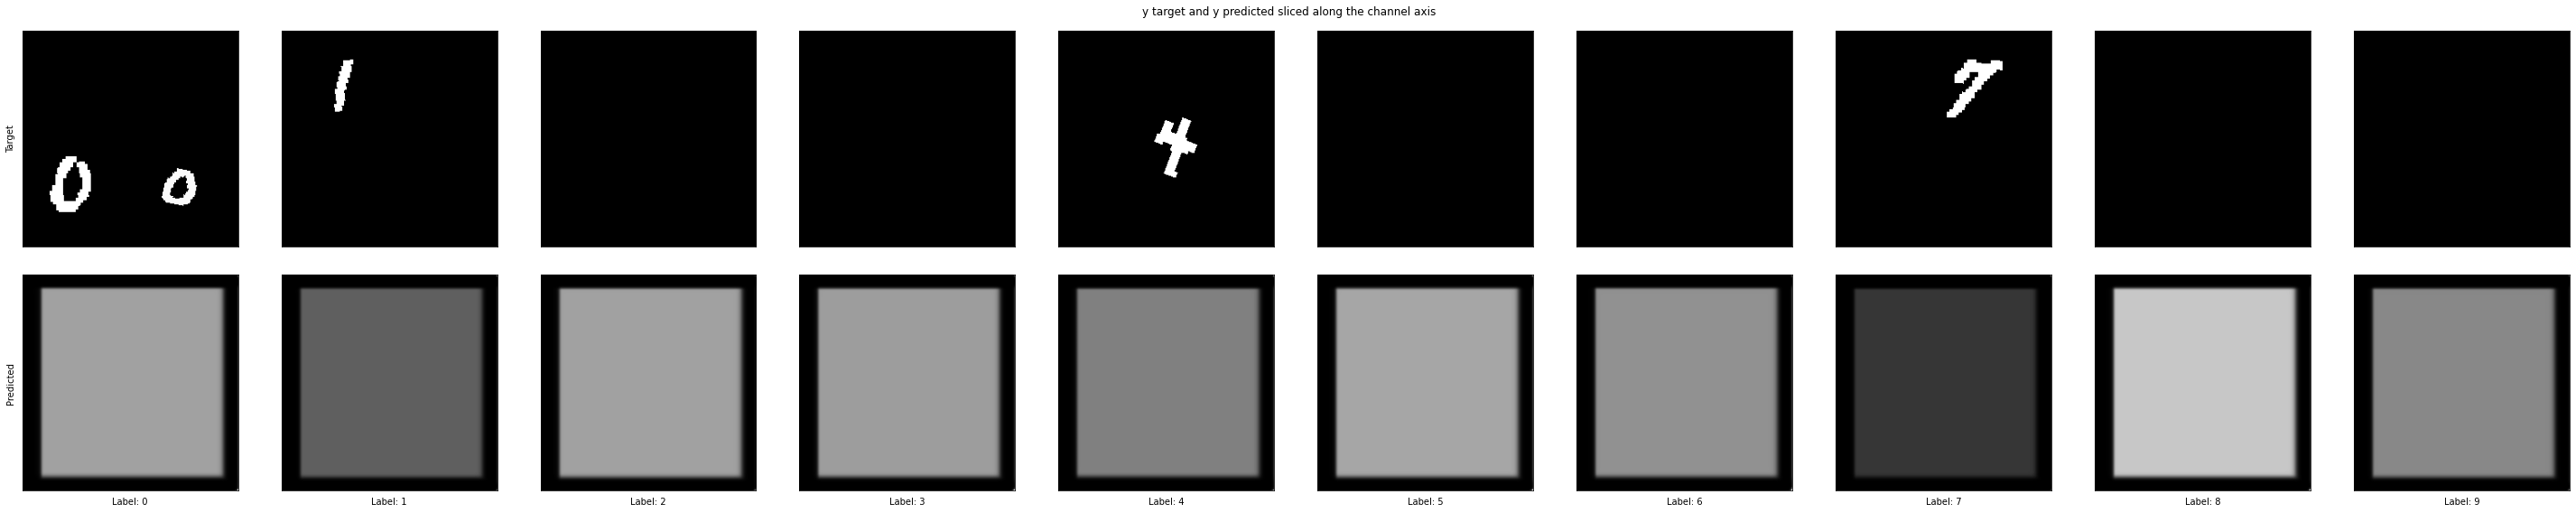

In [24]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image, display_grayscale_array, plot_class_masks

for _ in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    i = np.random.randint(len(test_y_predicted))
    print(f'Example {i}')
    display_grayscale_array(X_seg_test[i], ax=ax1, title='Input image')
    display_segmented_image(test_y_predicted[i], ax=ax2, title='Segmented image', threshold=0.5)
    plot_class_masks(y_seg_test[i], test_y_predicted[i], title='y target and y predicted sliced along the channel axis')

In [30]:
model.save('simple_model.h5')

#### Encoder Decoder

In [16]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(9, 9), activation='relu', input_shape=X_seg_train.shape[1:], padding='same')) # 9
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 17
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same', strides=(2,2))) # 25
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 50
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 58
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same', strides=(2,2))) # 66
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same')) # 132
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(filters=32, kernel_size=(9, 9), activation='relu', padding='same', strides=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(filters=32, kernel_size=(9, 9), activation='relu', padding='same', strides=(2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=(9, 9), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(9, 9), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=y_seg_train.shape[-1], kernel_size=(9, 9), activation='sigmoid', padding='same'))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      1312      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      41504     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      82976     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      82976     
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      82976     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        82976     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        8

In [17]:
history = model.fit(X_seg_train, y_seg_train, epochs=50,
                    validation_data=(X_seg_test, y_seg_test))

Epoch 1/50
32/32 [==============================] - 16s 341ms/step - loss: 0.8107 - binary_accuracy: 0.9711 - recall: 0.0141 - precision: 0.0065 - val_loss: 0.0995 - val_binary_accuracy: 0.9912 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 9s 271ms/step - loss: 0.0719 - binary_accuracy: 0.9909 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0608 - val_binary_accuracy: 0.9912 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 9s 271ms/step - loss: 0.0596 - binary_accuracy: 0.9909 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0560 - val_binary_accuracy: 0.9912 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/50
32/32 [==============================] - 9s 268ms/step - loss: 0.0557 - binary_accuracy: 0.9909 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0523 - val_binary_accuracy: 0.9912 - val_recall: 0.0000e+00 - val_precision: 0.

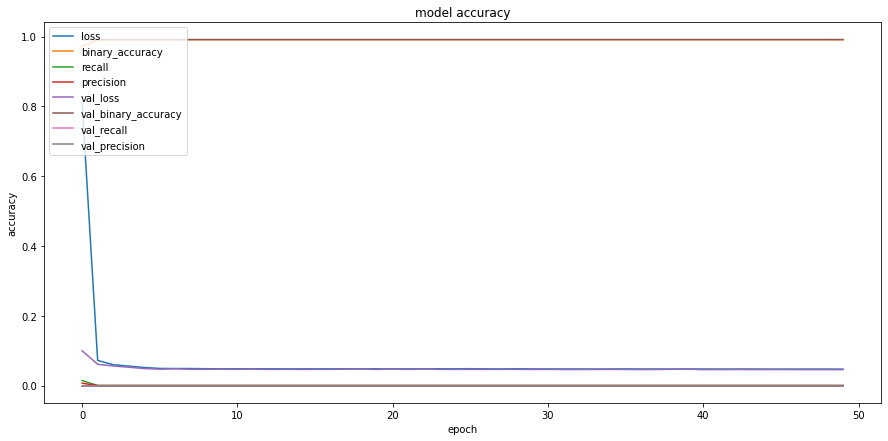

In [18]:
plt.rcParams['figure.figsize'] = (15,7) # Make the figures a bit bigger
plt.plot(history.history['loss'])
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['recall'])
plt.plot(history.history['precision'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_binary_accuracy'])
plt.plot(history.history['val_recall'])
plt.plot(history.history['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'binary_accuracy','recall','precision','val_loss', 'val_binary_accuracy','val_recall','val_precision'], loc='upper left')
plt.show()

In [19]:
test_y_predicted = model.predict(X_seg_test)

4/4 [==============================] - 0s 44ms/step


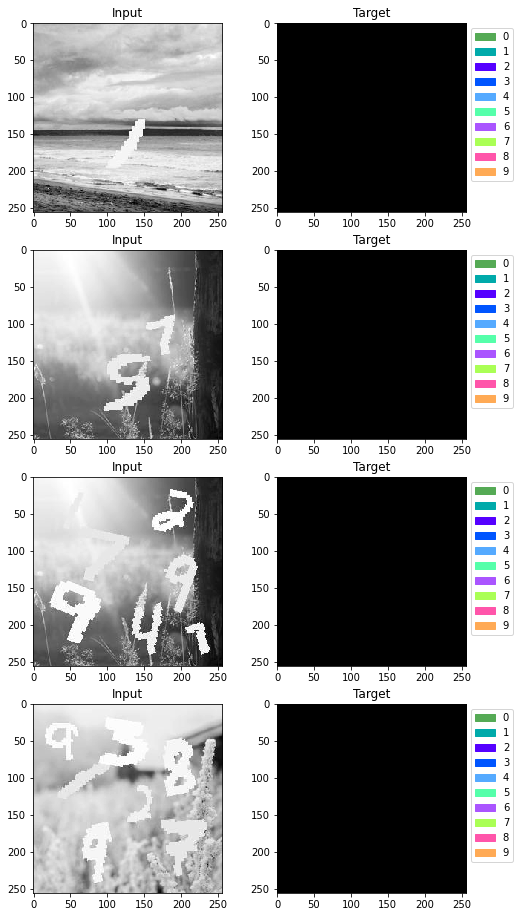

In [20]:
show_X_pred_y(X_seg_test, test_y_predicted)

In [48]:
# from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image, display_grayscale_array, plot_class_masks

# for _ in range(3):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#     i = np.random.randint(len(test_y_predicted))
#     print(f'Example {i}')
#     display_grayscale_array(X_seg_test[i], ax=ax1, title='Input image')
#     display_segmented_image(test_y_predicted[i], ax=ax2, title='Segmented image', threshold=0.5)
#     plot_class_masks(y_seg_test[i], test_y_predicted[i], title='y target and y predicted sliced along the channel axis')

In [49]:
model.save('encoder_decoder_model.h5')

#### UNet

In [14]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    # p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    # x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def create_unet():
    inputs = layers.Input(shape=(256,256,1))
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128)
#     # 4 - downsample
#     f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p3, 256)
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f3, 128)
    # 7 - upsample
    u7 = upsample_block(u6, f2, 64)
    # 8 - upsample
    u8 = upsample_block(u7, f1, 32)
#     # 9 - upsample
#     u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(10, 1, padding="same", activation = "sigmoid")(u8)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

tf.keras.backend.clear_session()

model = create_unet()
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [15]:
history = model.fit(X_seg_train, y_seg_train, epochs=100,
                    validation_data=(X_seg_test, y_seg_test))

Epoch 1/100
32/32 [==============================] - 18s 261ms/step - loss: 0.1990 - binary_accuracy: 0.9656 - recall: 0.0199 - precision: 0.0067 - val_loss: 0.0821 - val_binary_accuracy: 0.9904 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 5s 154ms/step - loss: 0.0498 - binary_accuracy: 0.9912 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0455 - val_binary_accuracy: 0.9904 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 5s 156ms/step - loss: 0.0358 - binary_accuracy: 0.9912 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0363 - val_binary_accuracy: 0.9904 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 5s 153ms/step - loss: 0.0324 - binary_accuracy: 0.9912 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.0366 - val_binary_accuracy: 0.9904 - val_recall: 0.0000e+00 - val_precision

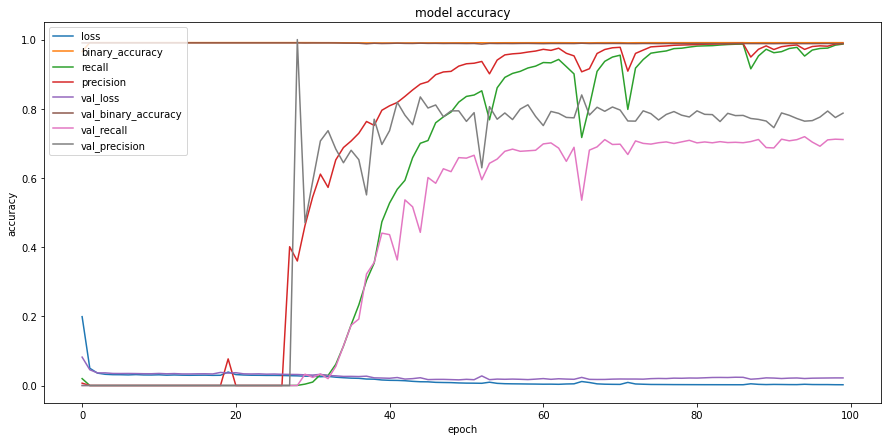

In [16]:
plt.rcParams['figure.figsize'] = (15,7) # Make the figures a bit bigger
plt.plot(history.history['loss'])
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['recall'])
plt.plot(history.history['precision'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_binary_accuracy'])
plt.plot(history.history['val_recall'])
plt.plot(history.history['val_precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'binary_accuracy','recall','precision','val_loss', 'val_binary_accuracy','val_recall','val_precision'], loc='upper left')
plt.show()

In [17]:
test_y_predicted = model.predict(X_seg_test)

4/4 [==============================] - 0s 38ms/step


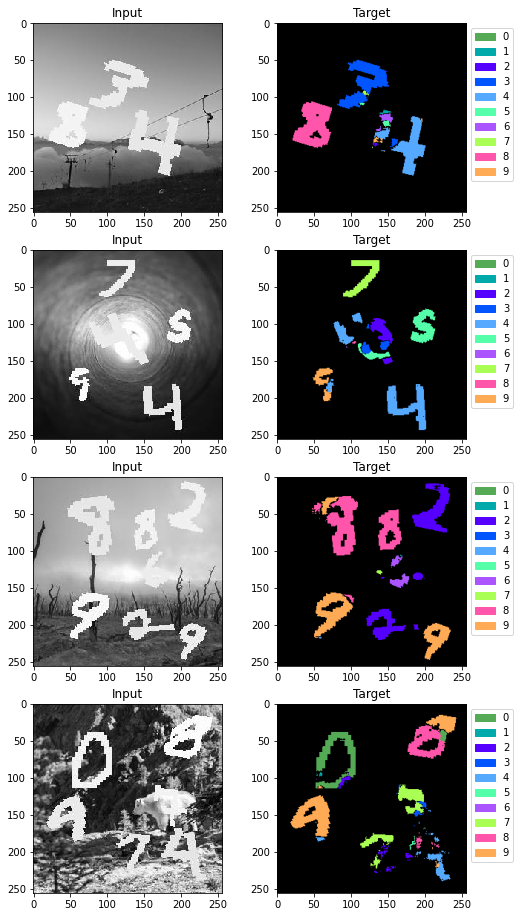

In [18]:
show_X_pred_y(X_seg_test, test_y_predicted)

Example 77


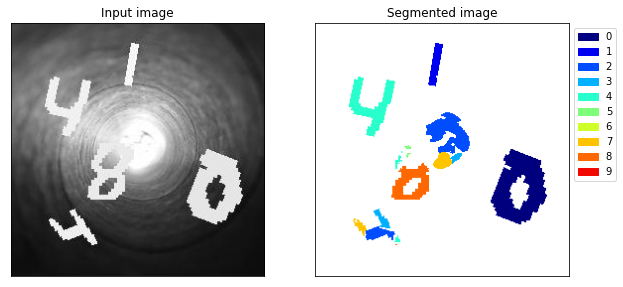

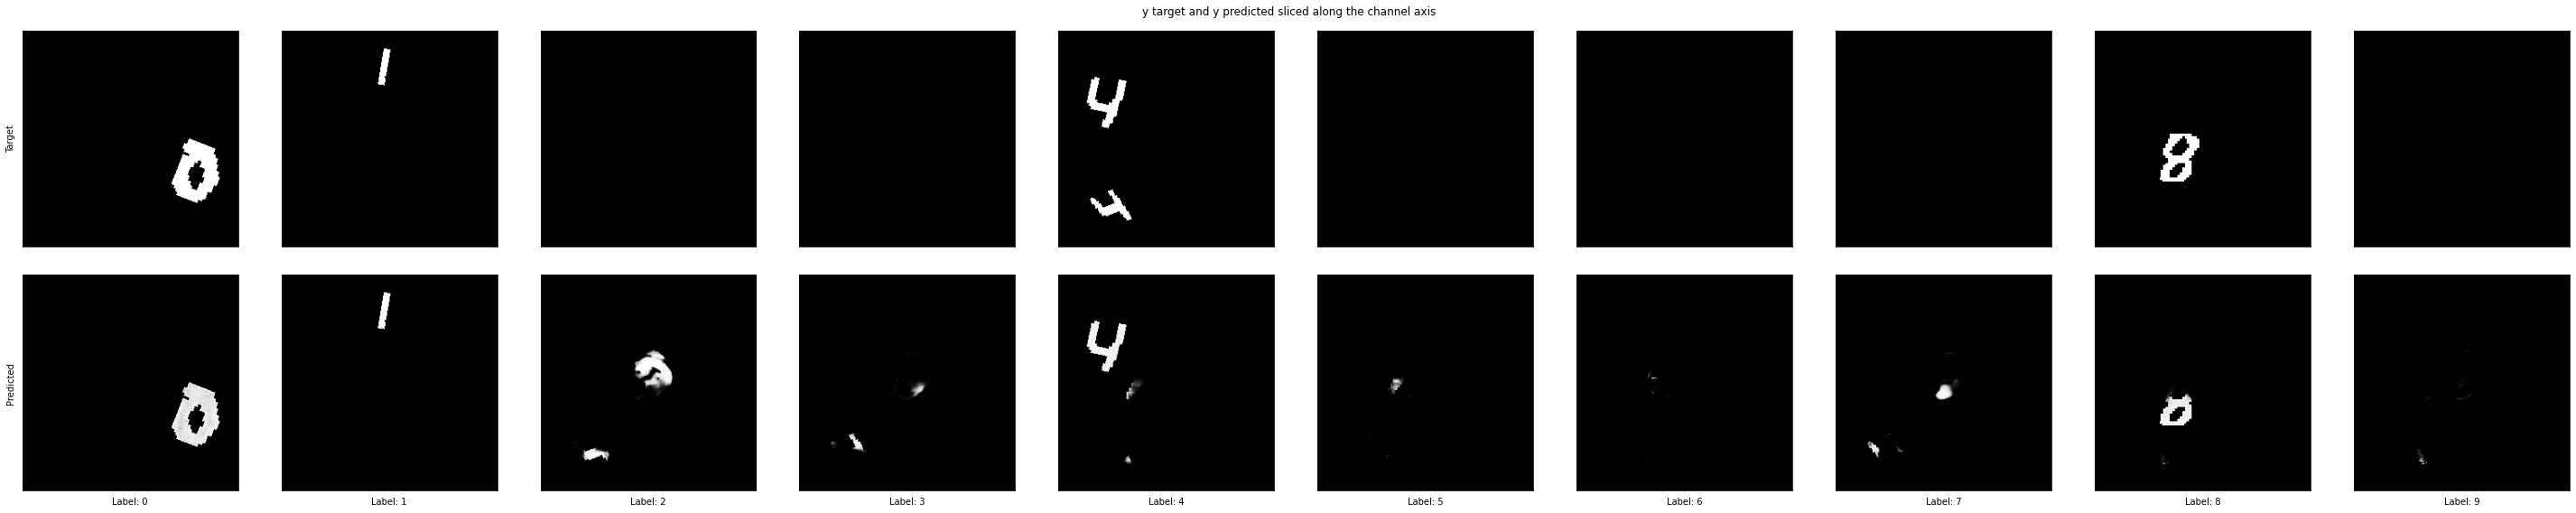

Example 82


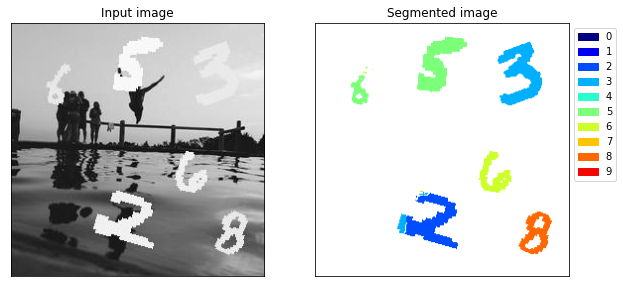

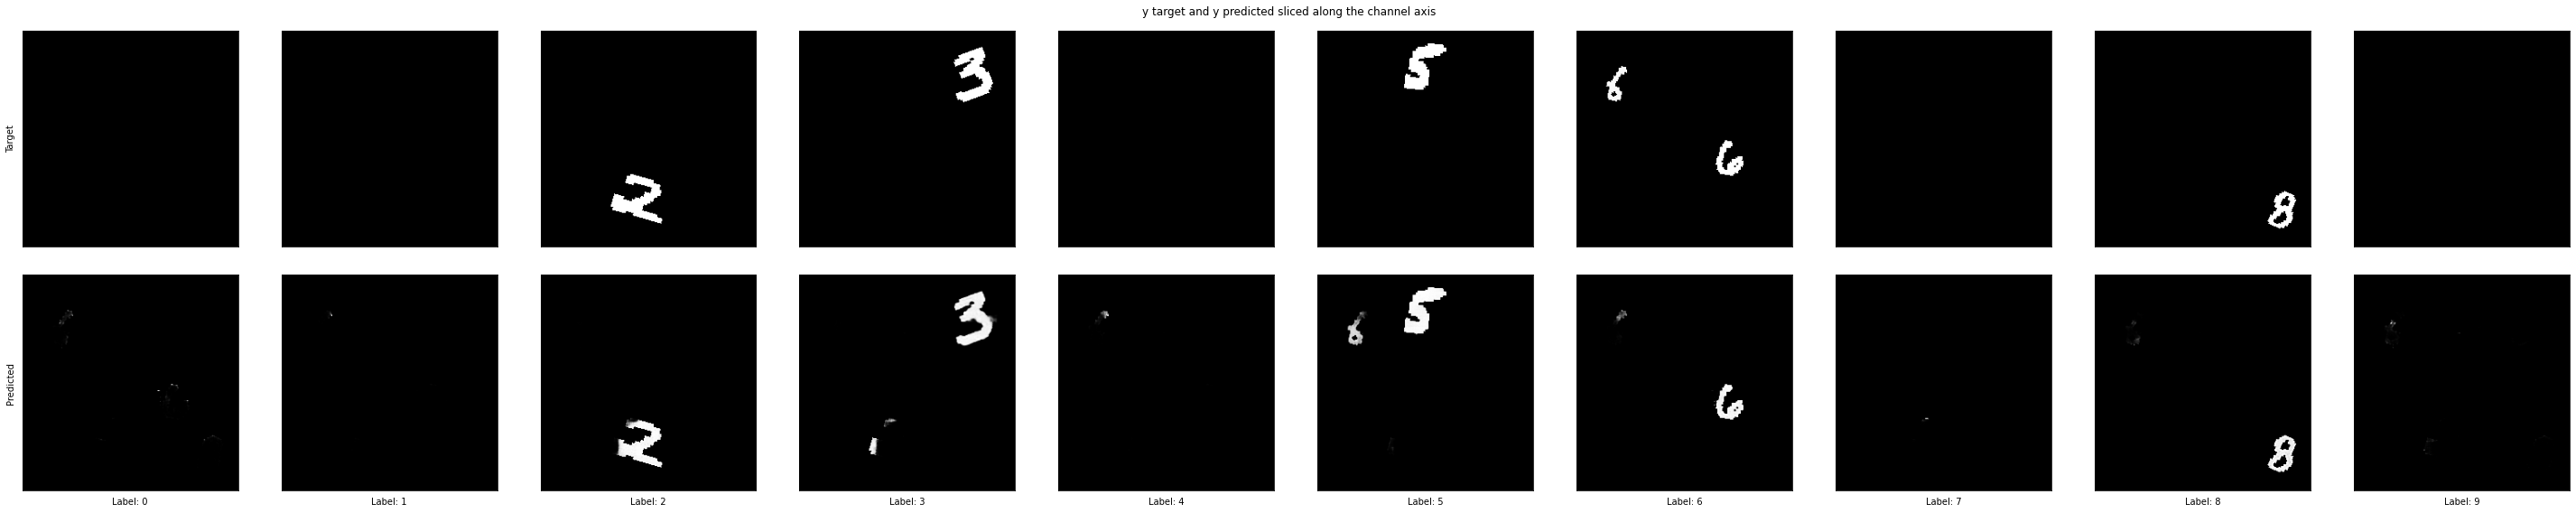

Example 33


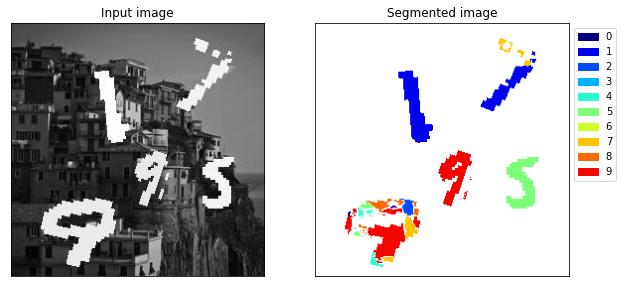

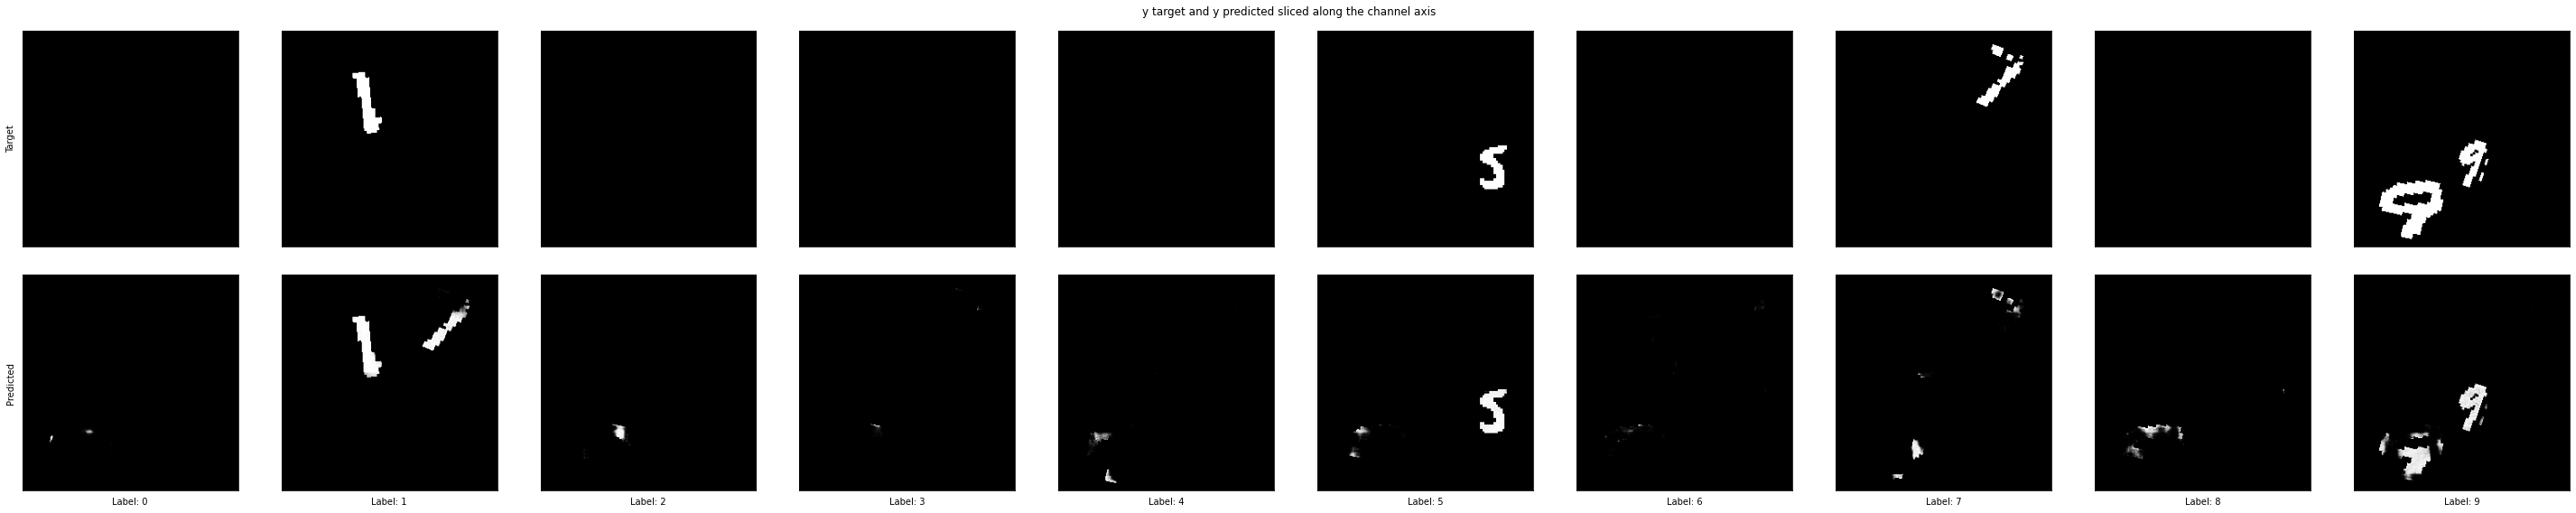

In [19]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image, display_grayscale_array, plot_class_masks

for _ in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    i = np.random.randint(len(test_y_predicted))
    print(f'Example {i}')
    display_grayscale_array(X_seg_test[i], ax=ax1, title='Input image')
    display_segmented_image(test_y_predicted[i], ax=ax2, title='Segmented image', threshold=0.5)
    plot_class_masks(y_seg_test[i], test_y_predicted[i], title='y target and y predicted sliced along the channel axis')

In [20]:
model.save('unet_model.h5')

#### Тестирование на реальных изображениях

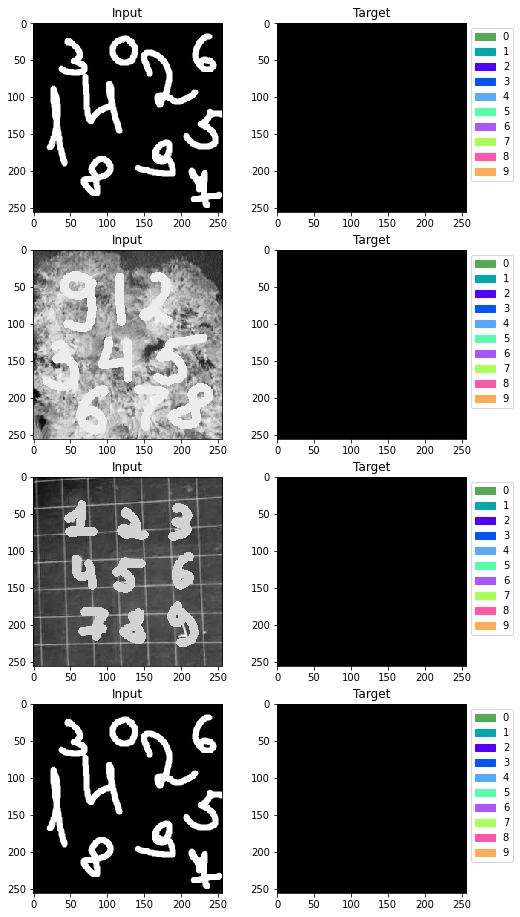

In [21]:
import os
import PIL
arr = os.listdir('./test')
X_manual_test = []
for image_path in arr:
    image = Image.open(f'./test/{image_path}').convert('L')
    inverted_image = PIL.ImageOps.invert(image)
    X_manual_test.append(np.array(inverted_image).reshape((256,256,1)) / 255)
X_manual_test = np.asarray(X_manual_test)
y_manual_test = np.zeros((len(arr),256,256,10))
show_X_y(X_manual_test,y_manual_test)

In [90]:
model = tf.keras.models.load_model('unet_model3.h5')

In [91]:
test_y_predicted = model.predict(X_manual_test)

1/1 [==============================] - 4s 4s/step


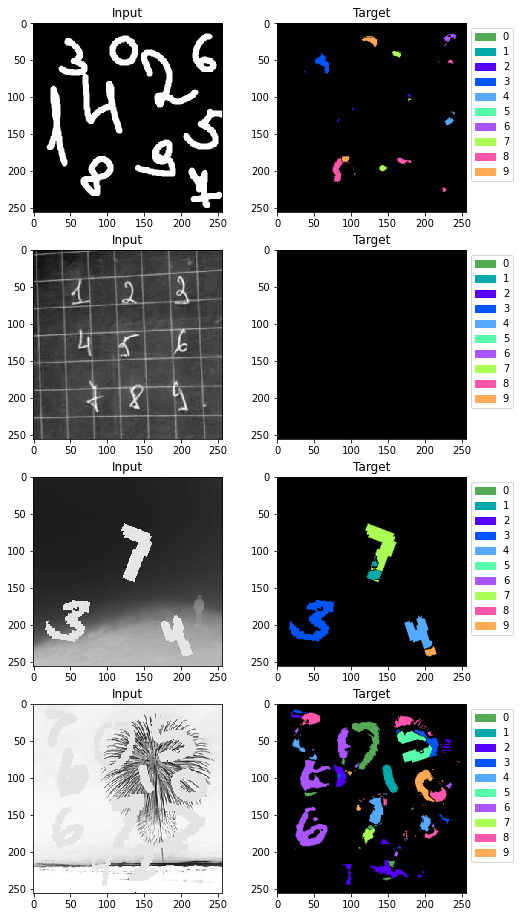

In [92]:
show_X_pred_y(X_manual_test, test_y_predicted)

Example 15


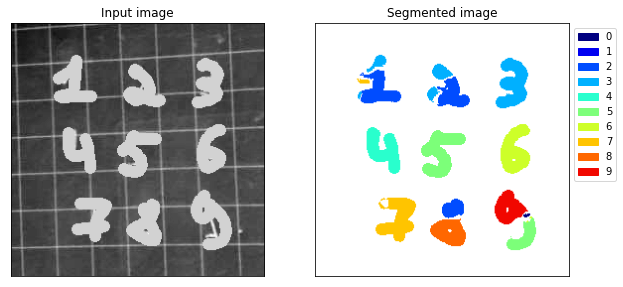

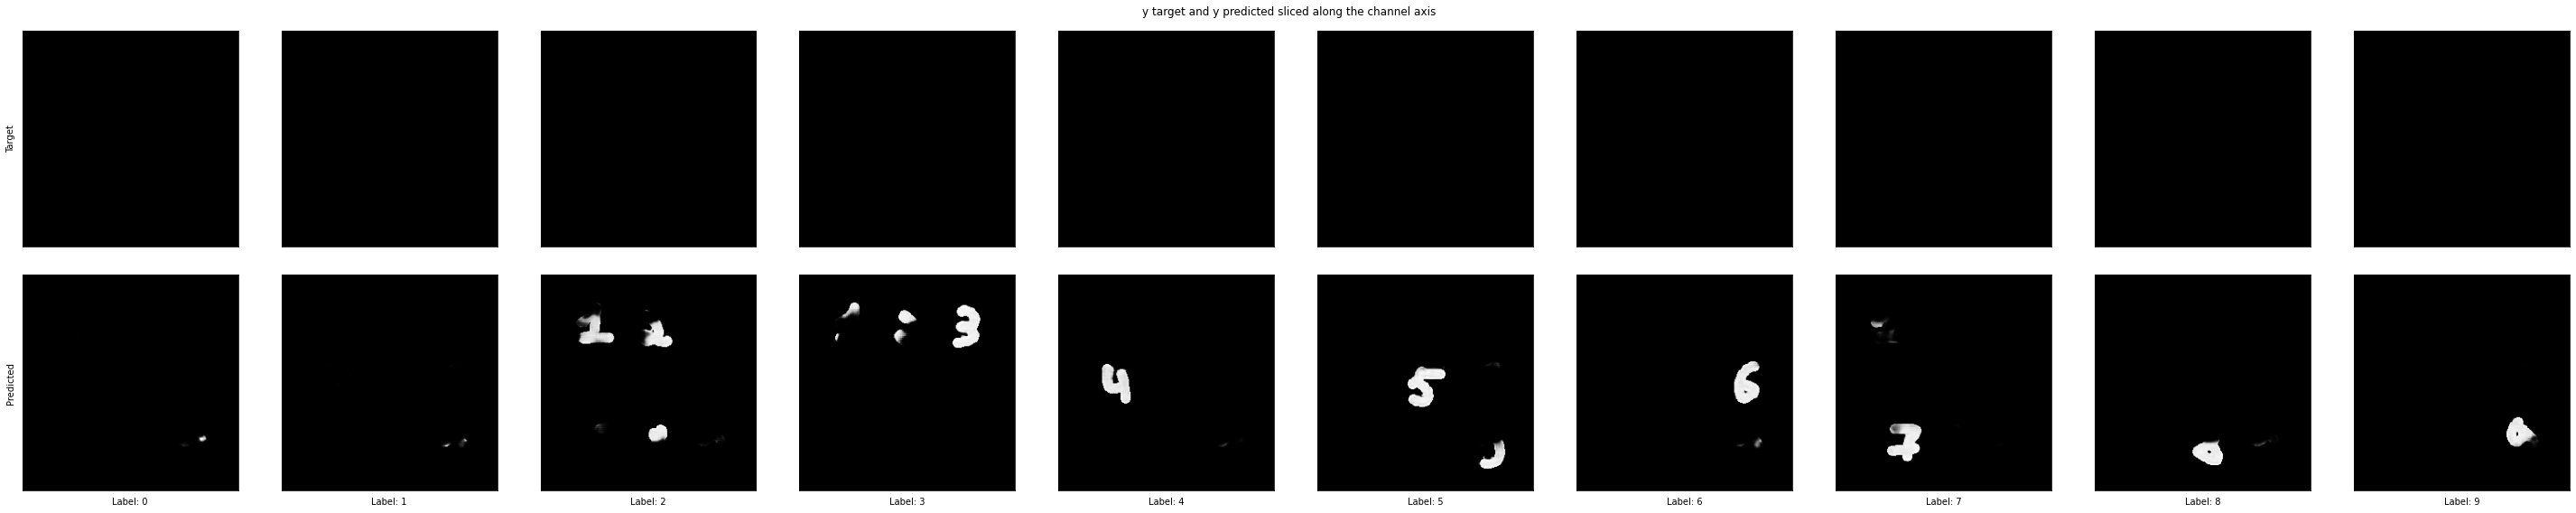

Example 4


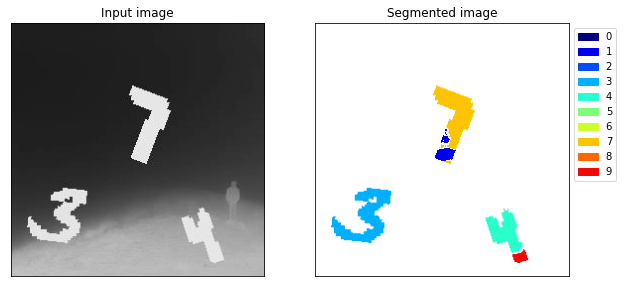

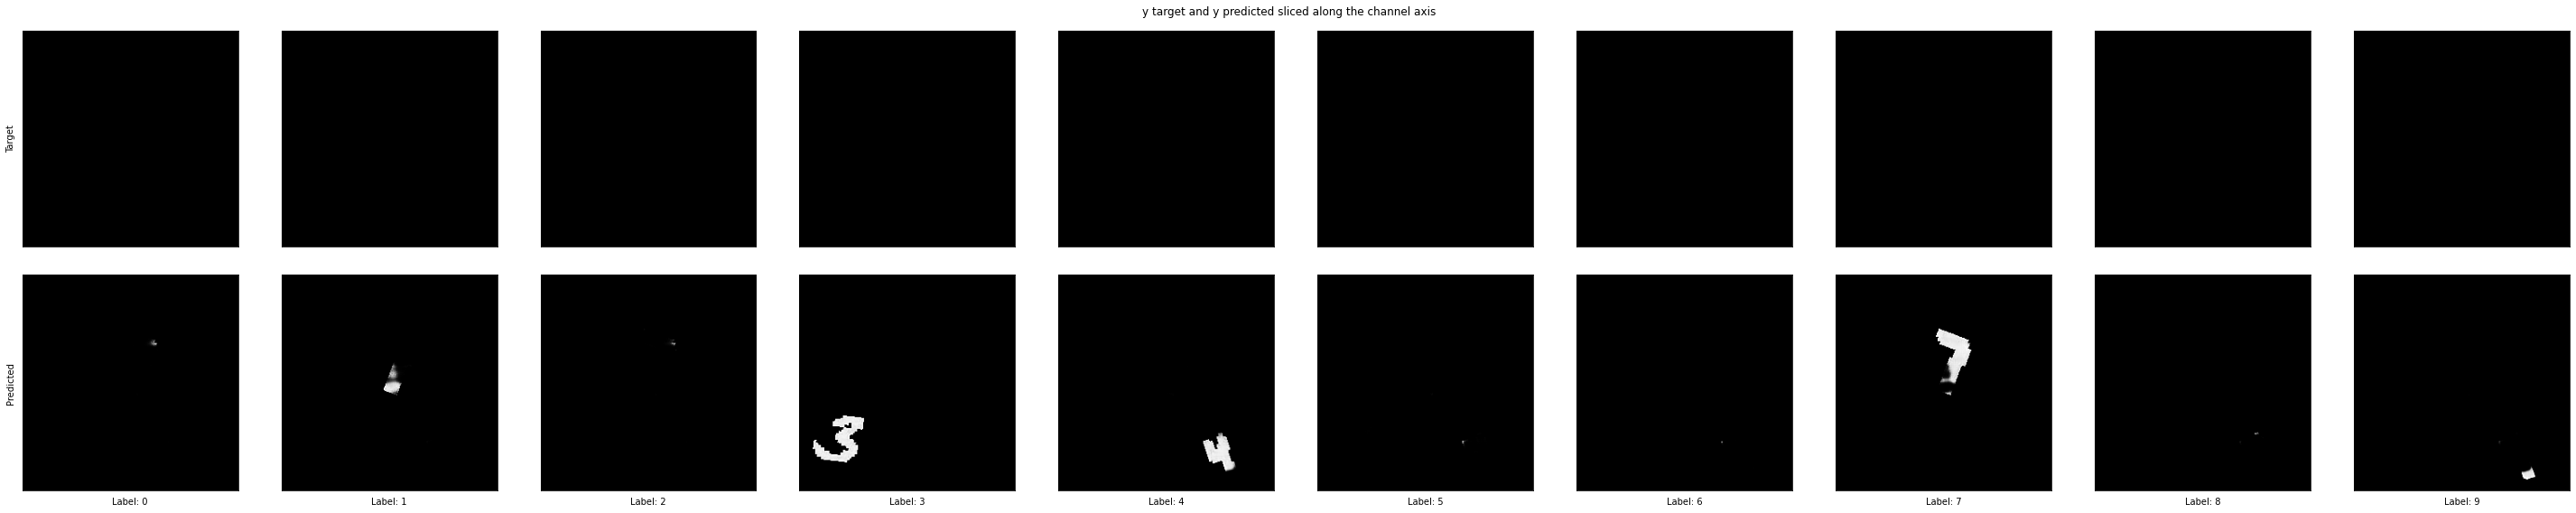

Example 8


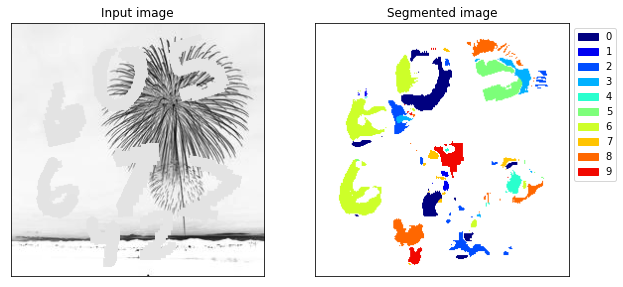

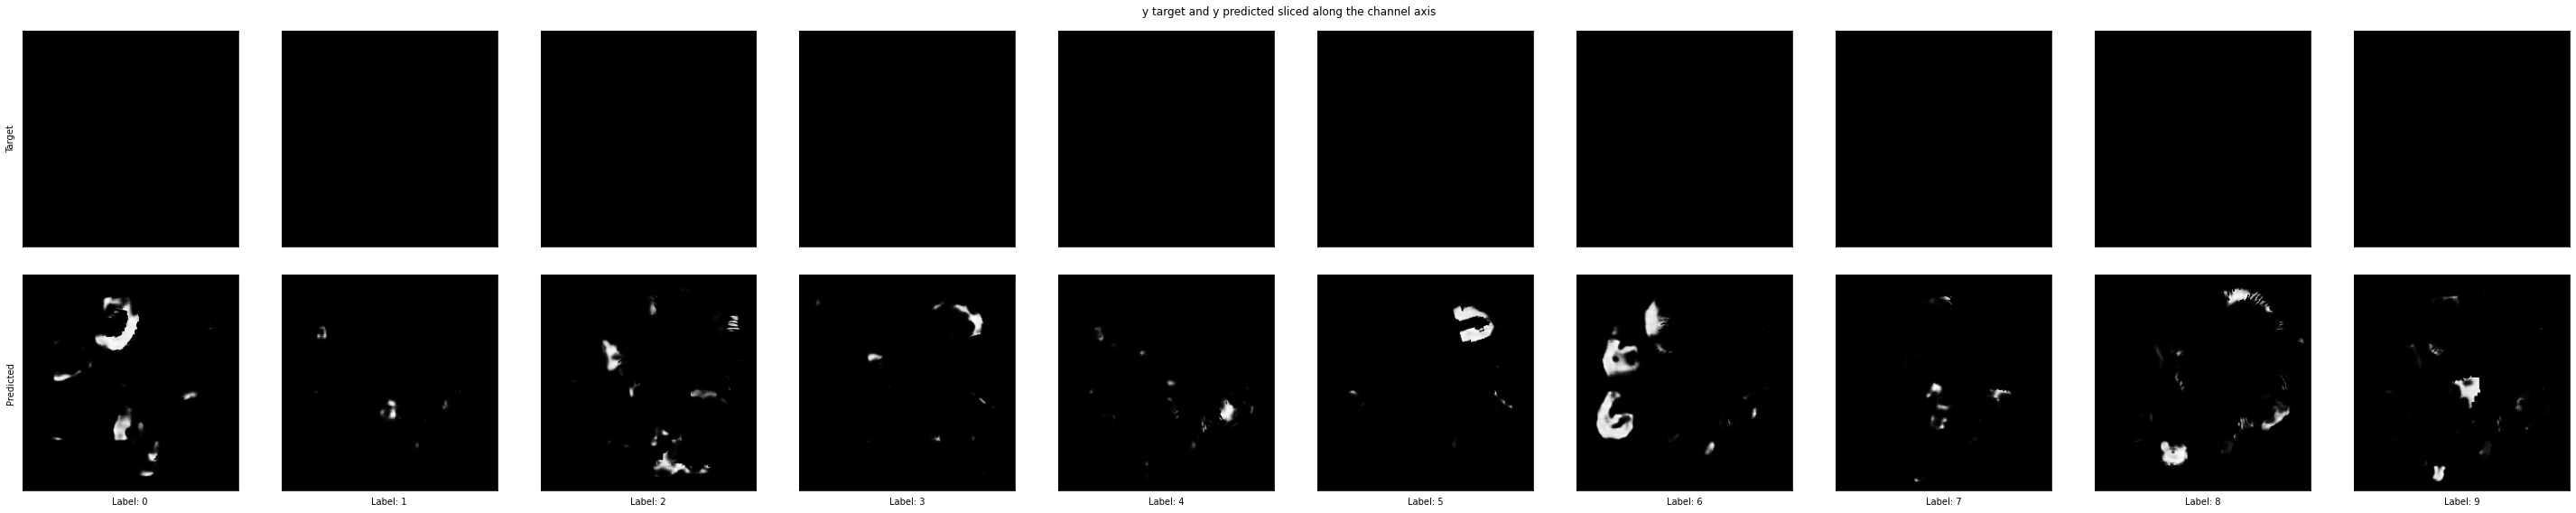

In [94]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_segmented_image, display_grayscale_array, plot_class_masks

for _ in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    i = np.random.randint(len(test_y_predicted))
    print(f'Example {i}')
    display_grayscale_array(X_manual_test[i], ax=ax1, title='Input image')
    display_segmented_image(test_y_predicted[i], ax=ax2, title='Segmented image', threshold=0.5)
    plot_class_masks(y_manual_test[i], test_y_predicted[i], title='y target and y predicted sliced along the channel axis')